In [ ]:
!pip install transformers==4.46.3


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 68.4 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.0
    Uninstalling tokenizers-0.21.0:
      Successfully uninstalled tokenizers-0.21.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.1
    Uninstalling transformers-4.47.1:
      Successfully uninstalled transformers-4.47.1


In [ ]:
import pandas as pd
import numpy as np
import re
def cleaning(s):
    s = str(s)
    s = re.sub('\s\W',' ',s)
    s = re.sub('\W,\s',' ',s)
    s = re.sub("\d+", "", s)
    s = re.sub('\s+',' ',s)
    s = re.sub('[!@#$_]', '', s)
    s = s.replace("co","")
    s = s.replace("https","")
    s = s.replace("[\w*"," ")
    return s
df = pd.read_csv("/content/Articles.csv", encoding="ISO-8859-1")
df = df.dropna()
text_data = open('Articles.txt', 'w')
for idx, item in df.iterrows():
  article = cleaning(item["Article"])
  text_data.write(article)
text_data.close()

In [20]:
from transformers import TextDataset, DataCollatorForLanguageModeling
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import Trainer, TrainingArguments
import matplotlib.pyplot as plt
def load_dataset(file_path, tokenizer, block_size = 128):
    dataset = TextDataset(
        tokenizer = tokenizer,
        file_path = file_path,
        block_size = block_size,
    )
    return dataset

def load_data_collator(tokenizer, mlm = False):
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=mlm,
    )
    return data_collator


def train(train_file_path,model_name,
          output_dir,
          overwrite_output_dir,
          per_device_train_batch_size,
          num_train_epochs,
          save_steps):
  tokenizer = GPT2Tokenizer.from_pretrained(model_name)
  train_dataset = load_dataset(train_file_path, tokenizer)
  data_collator = load_data_collator(tokenizer)

  tokenizer.save_pretrained(output_dir, safe_serialization=True)

  model = GPT2LMHeadModel.from_pretrained(model_name)

  model.save_pretrained(output_dir,safe_serialization=True)

  training_args = TrainingArguments(
          output_dir=output_dir,
          overwrite_output_dir=overwrite_output_dir,
          per_device_train_batch_size=per_device_train_batch_size,
          num_train_epochs=num_train_epochs,
      )

  trainer = Trainer(
          model=model,
          args=training_args,
          data_collator=data_collator,
          train_dataset=train_dataset,
  )

  trainer.train()
  trainer.save_model(output_dir)
  log_history = trainer.state.log_history
  log_df = pd.DataFrame(log_history)
  loss_data = log_df[log_df["loss"].notnull()]
  loss_data.to_csv(output_dir + "/loss_data.csv", index=False)
  plt.figure(figsize=(10, 6))
  plt.plot(loss_data["step"], loss_data["loss"], label="Training Loss")
  plt.xlabel("Steps")
  plt.ylabel("Loss")
  plt.title("Training Loss Over Steps")
  plt.legend()
  plt.grid()
  plt.show()

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


Step,Training Loss
500,3.689000
1000,3.418600
1500,3.171200
2000,3.121600
2500,2.982500
3000,2.954500
3500,2.867400
4000,2.841600
4500,2.790900


Step,Training Loss
500,3.689000
1000,3.418600
1500,3.171200
2000,3.121600
2500,2.982500
3000,2.954500
3500,2.867400
4000,2.841600
4500,2.790900
5000,2.783600


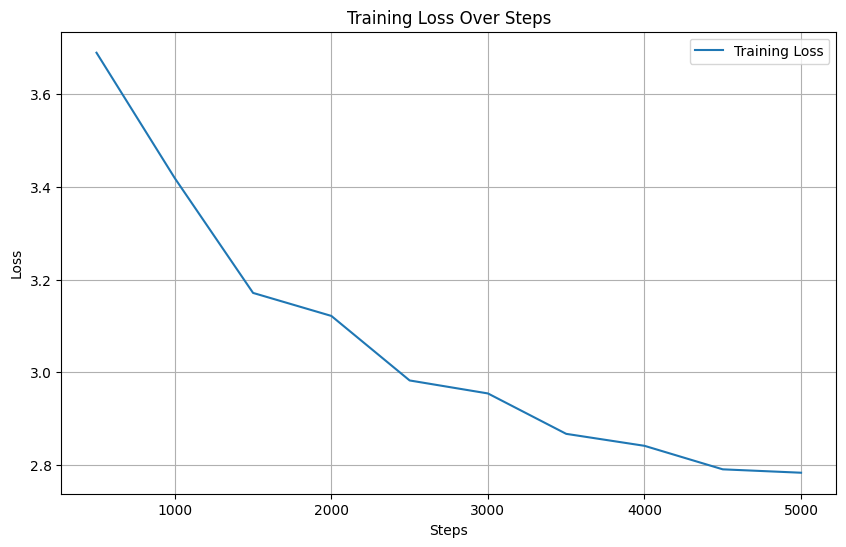

In [21]:
train_file_path = "/content/Articles.txt"
model_name = 'gpt2'
output_dir = '/content/Results2'
overwrite_output_dir = True
per_device_train_batch_size = 8
num_train_epochs = 5.0
save_steps = 5000
train(
    train_file_path=train_file_path,
    model_name=model_name,
    output_dir=output_dir,
    overwrite_output_dir=overwrite_output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    num_train_epochs=num_train_epochs,
    save_steps=save_steps
)